In [1]:
# imports:
import numpy as np
import math, os, pickle
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt

import statistics

In [51]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
def netPlot(instance, error):
    instance = list(range(0, instance))
    
    
    with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
        fig, ax = plt.subplots()
        ax.plot(instance, error)

        ax.set(xlabel='instance numebr (s)', ylabel='error (net)',
               title='Average Net Error for each batch run')
        ax.grid()

    plt.show()
    
def sigmoid(x):  
    return 1/(1+np.exp(-x))

def sigmoid_der(x):  
    return sigmoid(x) *(1-sigmoid (x))

def softmax(A):  
    expA = np.exp(A)
    return expA / expA.sum()

def load_objects(file):
    with open(file, 'rb') as input:
        return pickle.load(input)
    
def save_it_all(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def saveNet(wh, bh, wo, bo, fileName):
    weights = {"wh":wh, "bh":bh, "wo":wo, "bo":bo}
    save_it_all(weights, fileName)
    
def getArrayFromFile(name):
    array = genfromtxt(name, delimiter=',')
    return array

def mapTargetsToEncoded(targets, tMap):
    newTargets = []
    for item in targets.tolist():
        newTargets.append(tMap[int(item[0])])
    return newTargets

In [52]:
# load in fishing normalized set 
# data = getArrayFromFile("normalizeFish.csv")
data = getArrayFromFile("normDigit.csv")
inputs = data[:,0:data.shape[1]-1] # get the input values
targets = data[:, data.shape[1]-1:data.shape[1]] # get the class values

targetMap = load_objects("./digitTargetCleanDict.pkl")
oneHotTargets = np.asarray(mapTargetsToEncoded(targets, targetMap), dtype=np.float32)


In [53]:
instances = inputs.shape[0]
attributes = inputs.shape[1]

numInputNodes = attributes
numOutputNodes = 1 if np.unique(targets).shape[0] == 2 else np.unique(targets).shape[0]
numHiddenNodes = int((2/3)*(numInputNodes+numOutputNodes))

print("Input node num: "+ str(numInputNodes))
print("Hidden node num: "+ str(numHiddenNodes))
print("Output node num: " + str(numOutputNodes))

lowRange = (-1/math.sqrt(numInputNodes))
highRange = math.fabs(lowRange)

weightHidden = np.random.uniform(low=lowRange, high=highRange, size=(numInputNodes, numHiddenNodes, ))
biasHidden = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes))

weightOutput = np.random.uniform(low=lowRange, high=highRange, size=(numHiddenNodes, numOutputNodes))
biasOutput = np.random.uniform(low=lowRange, high=highRange, size=(numOutputNodes))

print()
print(str(weightHidden.shape))
print(str(biasHidden.shape))
print(str(weightOutput.shape))
print(str(biasOutput.shape))

print()
print(str(inputs.shape))
print()
learningRate = .5

errorCost = []
batchError = []

for epoch in range(55):
    trackedNetError= []
    print("------------Epoch: "+str(epoch)+"--")
    for instanceRow in range(0, instances):
        
        #### feedforward
        
        inputInstance = np.array([inputs[instanceRow]])
        targetInstance = np.array([oneHotTargets[instanceRow]])
        
        
        # Phase 1 inputs fed through to hidden
        zetaHidden = np.dot(inputInstance, weightHidden) + biasHidden
        activationHidden = sigmoid(zetaHidden)
        
        # Phase 2 hidden fed through to the output
        zetaOutput = np.dot(activationHidden, weightOutput) + biasOutput
        activationOutput = softmax(zetaOutput)

        #### backpropigate with the cross entropy cost function # bad step maybe
        # phase one 
        derivativecost_zetaOutput = activationOutput - targetInstance
#         print(derivativecost_zetaOutput.shape)
#         #print(derivativecost_zetaOutput)
#         print()

        derivativeZetaOutput_derivatieWeightOutput = activationHidden
#         print(derivativeZetaOutput_derivatieWeightOutput.shape)
#         #print(derivativeZetaOutput_derivatieWeightOutput)
#         print()

        derivativecost_weightOutput = np.dot(derivativeZetaOutput_derivatieWeightOutput.T, derivativecost_zetaOutput)
#         print(derivativecost_weightOutput.shape)
#         #print(derivativecost_weightOutput)
#         print()

        derivativecost_biasOutput = derivativecost_zetaOutput
#         print(derivativecost_biasOutput.shape)
#         #print(derivativecost_biasOutput)
#         print()
        #     # phase two
        derivativeZetaOutput_derivativeActivationHidden = weightOutput
#         print(derivativeZetaOutput_derivativeActivationHidden.shape)
#         #print(derivativeZetaOutput_derivativeActivationHidden)
#         print()
        derivativeCost_derivativeActivationHidden = np.dot(derivativecost_zetaOutput , derivativeZetaOutput_derivativeActivationHidden.T)
#         print(derivativeCost_derivativeActivationHidden.shape)
#         #print(derivativeCost_derivativeActivationHidden)
#         print()
        derivativeActivationHidden_derivativeZetaHidden = sigmoid_der(zetaHidden)
#         print(derivativeActivationHidden_derivativeZetaHidden.shape)
#         #print(derivativeActivationHidden_derivativeZetaHidden)
#         print()
        derivativeZetaHidden_derivativeWeightHidden = inputInstance
#         print(derivativeZetaHidden_derivativeWeightHidden.shape)
#         #print(derivativeZetaHidden_derivativeWeightHidden)
#         print()
        derivativeCost_weightHidden = np.dot(derivativeZetaHidden_derivativeWeightHidden.T, derivativeActivationHidden_derivativeZetaHidden * derivativeCost_derivativeActivationHidden)
#         print(derivativeCost_weightHidden.shape)
#         #print(derivativeCost_weightHidden)
#         print()
        derivativeCost_biasHidden = derivativeCost_derivativeActivationHidden * derivativeActivationHidden_derivativeZetaHidden
#         print(derivativeCost_biasHidden.shape)
#         #print(derivativeCost_biasHidden)
#         print()

        #     # Update Weights ================

        weightHidden -= learningRate * derivativeCost_weightHidden
#         print(weightHidden.shape)
#        # print(weightHidden)
#         print()
        biasHidden -= learningRate * derivativeCost_biasHidden.sum(axis=0)
#         print(biasHidden.shape)
#         #print(biasHidden)
#         print()
        weightOutput -= learningRate * derivativecost_weightOutput
#         print(weightOutput.shape)
#         #print(weightOutput)
#         print()
        biasOutput -= learningRate * derivativecost_biasOutput.sum(axis=0)
#         print(biasOutput.shape)
#         #print(biasOutput)
#         print()
        
        loss = np.sum(-targetInstance * np.log(activationOutput))
        trackedNetError.append(loss)
    avg_err = statistics.mean(trackedNetError)
    print("Loss: "+str(avg_err))
    batchError.append(avg_err)
    print()
        

#     print('Loss function value: ', loss)
#     errorCost.append(loss)
saveNet(weightHidden, biasHidden, weightOutput, biasOutput, "digitNet.pkl")

Input node num: 64
Hidden node num: 49
Output node num: 10

(64, 49)
(49,)
(49, 10)
(10,)

(3823, 64)

------------Epoch: 0--
Loss: 0.4660567189900945

------------Epoch: 1--
Loss: 0.18524212474773133

------------Epoch: 2--
Loss: 0.14559857663757322

------------Epoch: 3--
Loss: 0.10727740181125023

------------Epoch: 4--
Loss: 0.09677831099925924

------------Epoch: 5--
Loss: 0.1180722249132258

------------Epoch: 6--
Loss: 0.10695306323062123

------------Epoch: 7--
Loss: 0.1396962544718737

------------Epoch: 8--
Loss: 0.10426211788497522

------------Epoch: 9--
Loss: 0.07421119046134653

------------Epoch: 10--
Loss: 0.07924107210526693

------------Epoch: 11--
Loss: 0.05170658835947181

------------Epoch: 12--
Loss: 0.06255110290597059

------------Epoch: 13--
Loss: 0.05031874539714987

------------Epoch: 14--
Loss: 0.06509758223554821

------------Epoch: 15--
Loss: 0.04448082818069682

------------Epoch: 16--
Loss: 0.04326389911547305

------------Epoch: 17--
Loss: 0.02610762013

FileNotFoundError: [Errno 2] No such file or directory: ''

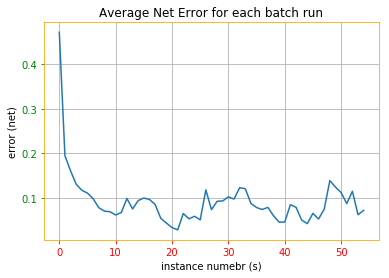

In [49]:
netPlot(55, batchError)